# Exploring all data from a tissue

This tutorial provides a series of examples for how to explore and query the Census in the context of a single tissue, lung. We will summarize cell and gene metadata, then fetch the single-cell expression counts and perform some basic data explorations via [Scanpy](https://scanpy.readthedocs.io/en/stable/) 


**Contents**

1. Learning about the human lung data.
   1. Learning about cells of the lung.
   2. Learning about genes of the lung .
2. Fetching all single-cell human lung data from the Census.
3. Calculating QC metrics of the lung data.
4. Creating a normalized expression layer and embeddings.

⚠️ Note that the Census RNA data includes duplicate cells present across multiple datasets. Duplicate cells can be filtered in or out using the cell metadata variable `is_primary_data` which is described in the [Census schema](https://github.com/chanzuckerberg/cellxgene-census/blob/main/docs/cellxgene_census_schema.md#repeated-data).

## Learning about the lung data in the Census

First we will open the Census. If you are not familiar with the basics of the Census API you should take a look at notebook [Learning about the CZ CELLxGENE Census](https://cellxgene-census.readthedocs.io/en/latest/notebooks/analysis_demo/comp_bio_census_info.html)


In [1]:
import cellxgene_census
import numpy as np
import pandas as pd
import scanpy as sc

census = cellxgene_census.open_soma()

The "stable" release is currently 2023-07-25. Specify 'census_version="2023-07-25"' in future calls to open_soma() to ensure data consistency.


Let's first take a look at the number of cells from human lung:


In [2]:
summary_table = census["census_info"]["summary_cell_counts"].read().concat().to_pandas()

summary_table.query("organism == 'Homo sapiens' & category == 'tissue_general' & label =='lung'")

,soma_joinid,organism,category,ontology_term_id,unique_cell_count,total_cell_count,label
980,980,Homo sapiens,tissue_general,UBERON:0002048,2907156,6011592,lung


There you can see the total of cells of under `total_cell_count` and the unique number cells under `unique_cell_count` (i.e. after removing cells that were included in multiple datasets).

Let's now take a look at the cell and gene information of this slice of the Census.

### Learning about cells of lung data

Let's load the cell metadata for all lung cells and select only the unique cells using `is_primary_data`.


In [3]:
lung_obs = cellxgene_census.get_obs(
    census, "homo_sapiens", value_filter="tissue_general == 'lung' and is_primary_data == True"
)
lung_obs

,soma_joinid,dataset_id,assay,assay_ontology_term_id,cell_type,cell_type_ontology_term_id,development_stage,development_stage_ontology_term_id,disease,disease_ontology_term_id,...,is_primary_data,self_reported_ethnicity,self_reported_ethnicity_ontology_term_id,sex,sex_ontology_term_id,suspension_type,tissue,tissue_ontology_term_id,tissue_general,tissue_general_ontology_term_id
0,5945423,9f222629-9e39-47d0-b83f-e08d610c7479,10x 3' v2,EFO:0009899,native cell,CL:0000003,unknown,unknown,normal,PATO:0000461,...,True,unknown,unknown,unknown,unknown,cell,lung,UBERON:0002048,lung,UBERON:0002048
1,5945426,9f222629-9e39-47d0-b83f-e08d610c7479,Drop-seq,EFO:0008722,ciliated columnar cell of tracheobronchial tree,CL:0002145,57-year-old human stage,HsapDv:0000151,pulmonary fibrosis,MONDO:0002771,...,True,unknown,unknown,male,PATO:0000384,cell,lung,UBERON:0002048,lung,UBERON:0002048
2,5945428,9f222629-9e39-47d0-b83f-e08d610c7479,10x 3' transcription profiling,EFO:0030003,"CD8-positive, alpha-beta T cell",CL:0000625,unknown,unknown,squamous cell lung carcinoma,MONDO:0005097,...,True,unknown,unknown,unknown,unknown,cell,lung,UBERON:0002048,lung,UBERON:0002048
3,5945432,9f222629-9e39-47d0-b83f-e08d610c7479,10x 3' v2,EFO:0009899,"CD4-positive, alpha-beta T cell",CL:0000624,unknown,unknown,lung adenocarcinoma,MONDO:0005061,...,True,unknown,unknown,unknown,unknown,cell,lung,UBERON:0002048,lung,UBERON:0002048
4,5945441,9f222629-9e39-47d0-b83f-e08d610c7479,10x 3' v2,EFO:0009899,"CD8-positive, alpha-beta T cell",CL:0000625,unknown,unknown,lung adenocarcinoma,MONDO:0005061,...,True,unknown,unknown,unknown,unknown,cell,lung,UBERON:0002048,lung,UBERON:0002048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2907151,56400868,8c42cfd0-0b0a-46d5-910c-fc833d83c45e,10x 3' v2,EFO:0009899,pericyte,CL:0000669,51-year-old human stage,HsapDv:0000145,normal,PATO:0000461,...,True,unknown,unknown,female,PATO:0000383,cell,lung,UBERON:0002048,lung,UBERON:0002048
2907152,56400869,8c42cfd0-0b0a-46d5-910c-fc833d83c45e,10x 3' v2,EFO:0009899,pericyte,CL:0000669,51-year-old human stage,HsapDv:0000145,normal,PATO:0000461,...,True,unknown,unknown,female,PATO:0000383,cell,lung,UBERON:0002048,lung,UBERON:0002048
2907153,56400870,8c42cfd0-0b0a-46d5-910c-fc833d83c45e,10x 3' v2,EFO:0009899,pericyte,CL:0000669,51-year-old human stage,HsapDv:0000145,normal,PATO:0000461,...,True,unknown,unknown,female,PATO:0000383,cell,lung,UBERON:0002048,lung,UBERON:0002048
2907154,56400871,8c42cfd0-0b0a-46d5-910c-fc833d83c45e,10x 3' v2,EFO:0009899,pericyte,CL:0000669,51-year-old human stage,HsapDv:0000145,normal,PATO:0000461,...,True,unknown,unknown,female,PATO:0000383,cell,lung,UBERON:0002048,lung,UBERON:0002048


You can see that the number or rows represents the total number of unique lung cells in the Census. Now let's take a deeper dive into the characteristics of these cells.

#### Datasets

First let's start by looking at what are the datasets and collections from [CELLxGENE Discover](https://cellxgene.cziscience.com/collections) contributing to lung. For this we will use the dataset table at `census["census-info"]["datasets"]` that contains metadata of all datasets used to build this Census.


In [4]:
census_datasets = (
    census["census_info"]["datasets"]
    .read(column_names=["collection_name", "dataset_title", "dataset_id", "soma_joinid"])
    .concat()
    .to_pandas()
)
census_datasets = census_datasets.set_index("dataset_id")
census_datasets

,collection_name,dataset_title,soma_joinid
dataset_id,,,
f171db61-e57e-4535-a06a-35d8b6ef8f2b,Spatial multiomics map of trophoblast developm...,donor_p13_trophoblasts,0
ecf2e08e-2032-4a9e-b466-b65b395f4a02,Spatial multiomics map of trophoblast developm...,All donors trophoblasts,1
74cff64f-9da9-4b2a-9b3b-8a04a1598040,Spatial multiomics map of trophoblast developm...,All donors all cell states (in vivo),2
5af90777-6760-4003-9dba-8f945fec6fdf,Mapping single-cell transcriptomes in the intr...,Single-cell transcriptomic datasets of Renal c...,3
bd65a70f-b274-4133-b9dd-0d1431b6af34,Single-cell sequencing links multiregional imm...,Single-cell sequencing links multiregional imm...,4
...,...,...,...
f9ad5649-f372-43e1-a3a8-423383e5a8a2,Molecular characterization of selectively vuln...,Molecular characterization of selectively vuln...,588
456e8b9b-f872-488b-871d-94534090a865,Single-cell atlas of peripheral immune respons...,Single-cell atlas of peripheral immune respons...,589
2adb1f8a-a6b1-4909-8ee8-484814e2d4bf,Construction of a human cell landscape at sing...,Construction of a human cell landscape at sing...,590


The `obs` cell metadata `pandas.DataFrame` contains a column `dataset_id` that can be used for joining to the `census_dataset` `pandas.DataFrame` we just created.

So let's take a look at the cell counts per `dataset_id` of the lung slice and then join to the dataset table to append the human-readable labels.


In [5]:
dataset_cell_counts = pd.DataFrame(lung_obs[["dataset_id"]].value_counts())
dataset_cell_counts = dataset_cell_counts.rename(columns={0: "cell_counts"})
dataset_cell_counts = dataset_cell_counts.merge(census_datasets, on="dataset_id")

dataset_cell_counts

,count,collection_name,dataset_title,soma_joinid
dataset_id,,,,
1e6a6ef9-7ec9-4c90-bbfb-2ad3c3165fd1,1028006,High-resolution single-cell atlas reveals dive...,The single-cell lung cancer atlas (LuCA) -- ex...,314
9f222629-9e39-47d0-b83f-e08d610c7479,784630,The integrated Human Lung Cell Atlas,An integrated cell atlas of the human lung in ...,56
f7c1c579-2dc0-47e2-ba19-8165c5a0e353,217738,A human cell atlas of fetal gene expression,Survey of human embryonic development,483
d8da613f-e681-4c69-b463-e94f5e66847f,116313,A molecular single-cell lung atlas of lethal C...,A molecular single-cell lung atlas of lethal C...,80
576f193c-75d0-4a11-bd25-8676587e6dc2,90384,HTAN MSK - Single cell profiling reveals novel...,Combined samples,377
d41f45c1-1b7b-4573-a998-ac5c5acb1647,82991,HTAN MSK - Transcriptional connectivity of reg...,Transcriptional connectivity of regulatory T c...,58
3dc61ca1-ce40-46b6-8337-f27260fd9a03,71752,A human fetal lung cell atlas uncovers proxima...,All cells,325
8c42cfd0-0b0a-46d5-910c-fc833d83c45e,60993,A molecular cell atlas of the human lung from ...,"Krasnow Lab Human Lung Cell Atlas, 10X",592
2672b679-8048-4f5e-9786-f1b196ccfd08,57019,"scRNA-seq assessment of the human lung, spleen...",Lung Parenchyma,416


These are all the datasets lung cells whose counts are reprensented in the column `cell_counts`. The top collections with lung data are:

1. [The integrated Human Lung Cell Atlas](https://cellxgene.cziscience.com/collections/6f6d381a-7701-4781-935c-db10d30de293).
2. [A human cell atlas of fetal gene expression](https://cellxgene.cziscience.com/collections/c114c20f-1ef4-49a5-9c2e-d965787fb90c).
3. [High-resolution single-cell atlas reveals diversity and plasticity of tumor-associated neutrophils in non-small cell lung cancer](https://cellxgene.cziscience.com/collections/edb893ee-4066-4128-9aec-5eb2b03f8287).
4. [HTAN MSK - Single cell profiling reveals novel tumor and myeloid subpopulations in small cell lung cancer](https://cellxgene.cziscience.com/collections/62e8f058-9c37-48bc-9200-e767f318a8ec).
5. [A human fetal lung cell atlas uncovers proximal-distal gradients of differentiation and key regulators of epithelial fates.](https://cellxgene.cziscience.com/collections/2d2e2acd-dade-489f-a2da-6c11aa654028).

#### Assays

Let's use similar logic to take a look at all the assays available for human lung data. This tells us that most assays are from 10x technologies and sci-RNA-seq.


In [6]:
lung_obs[["assay"]].value_counts()

assay                                   
10x 3' v2                                   1236968
10x 3' v3                                    702074
10x 5' v1                                    262323
sci-RNA-seq                                  217738
BD Rhapsody Whole Transcriptome Analysis     122902
10x 3' transcription profiling                97432
Drop-seq                                      65220
single cell library construction              58981
10x 5' v2                                     41852
microwell-seq                                 33698
Smart-seq2                                    25662
inDrop                                        25652
10x 3' v1                                      8638
Seq-Well                                       8016
Name: count, dtype: int64

#### Disease

And now let's take a look at diseased cell counts, with `normal` indicating non-diseased cells.


In [7]:
lung_obs[["disease"]].value_counts()

disease                              
normal                                   1164084
lung adenocarcinoma                       772120
COVID-19                                  331019
squamous cell lung carcinoma              209675
non-small cell lung carcinoma             120796
chronic obstructive pulmonary disease      55254
pulmonary fibrosis                         51343
interstitial lung disease                  45714
pneumonia                                  31923
pulmonary emphysema                        31792
small cell lung carcinoma                  31540
lung large cell carcinoma                  21167
cystic fibrosis                            17590
lymphangioleiomyomatosis                   12374
pleomorphic carcinoma                      10765
Name: count, dtype: int64

#### Sex

There doesn't seem to be strong biases for sex.


In [8]:
lung_obs[["sex"]].value_counts()

sex    
male       1402565
female     1122990
unknown     381601
Name: count, dtype: int64

#### Cell vs nucleus

The majority of data are from cells and not nucleus.


In [9]:
lung_obs[["suspension_type"]].value_counts()

suspension_type
cell               2468587
nucleus             438569
Name: count, dtype: int64

#### Cell types

Let's take a look at the counts of the top 20 cell types.


In [10]:
lung_obs[["cell_type"]].value_counts().head(20)

cell_type                                      
alveolar macrophage                                291507
native cell                                        263362
CD4-positive, alpha-beta T cell                    211456
CD8-positive, alpha-beta T cell                    189471
macrophage                                         154415
type II pneumocyte                                 128463
epithelial cell of lower respiratory tract         105090
classical monocyte                                 102303
natural killer cell                                 95953
T cell                                              92846
stromal cell                                        87714
B cell                                              81125
malignant cell                                      75917
plasma cell                                         64551
epithelial cell                                     59353
fibroblast                                          45305
capillary endothelial ce

#### Sub-tissues

We can look at the original tissue annotations that were mapped to "lung".


In [11]:
lung_obs[["tissue"]].value_counts()

tissue                   
lung                         2576327
lung parenchyma               147410
alveolus of lung               54085
lingula of left lung           35284
upper lobe of right lung       32099
lower lobe of left lung        17854
right lung                     12880
upper lobe of left lung        10113
left lung                       9276
lower lobe of right lung        7981
middle lobe of right lung       3847
Name: count, dtype: int64

### Learning about genes of lung data

Let's load the gene metadata of the Census.


In [12]:
lung_var = cellxgene_census.get_var(census, "homo_sapiens")
lung_var

,soma_joinid,feature_id,feature_name,feature_length
0,0,ENSG00000121410,A1BG,3999
1,1,ENSG00000268895,A1BG-AS1,3374
2,2,ENSG00000148584,A1CF,9603
3,3,ENSG00000175899,A2M,6318
4,4,ENSG00000245105,A2M-AS1,2948
...,...,...,...,...
60659,60659,ENSG00000288719,RP4-669P10.21,4252
60660,60660,ENSG00000288720,RP11-852E15.3,7007
60661,60661,ENSG00000288721,RP5-973N23.5,7765
60662,60662,ENSG00000288723,RP11-553N16.6,1015


You can see the total number of genes represented by the number of rows. This number is actually misleading because it is the join of all genes in the Census. However we know that the lung data comes from a subset of datasets.

So let's take a look at the number of genes that were measured in each of those datasets.

To accomplish this we can use the "dataset presence matrix" at `census["census_data"]["homo_sapiens"].ms["RNA"]["feature_dataset_presence_matrix"]`. This is a boolean matrix `N x M` where `N` is the number of datasets and `M` is the number of genes in the Census.

So we can select the rows corresponding to the lung datasets and perform a row-wise sum.


In [13]:
presence_matrix = cellxgene_census.get_presence_matrix(census, "Homo sapiens", "RNA")
presence_matrix = presence_matrix[dataset_cell_counts.soma_joinid, :]

In [14]:
presence_matrix.sum(axis=1).A1

array([17811, 50259, 44150, 34265, 22447, 23642, 26347, 20921, 24672,
       27705, 27243, 26323, 27181, 23203, 57042, 32610, 29620, 26454,
       23705, 38676, 47307, 23740, 22552, 20594, 19952], dtype=uint64)

In [15]:
genes_measured = presence_matrix.sum(axis=1).A1
dataset_cell_counts["genes_measured"] = genes_measured
dataset_cell_counts

,count,collection_name,dataset_title,soma_joinid,genes_measured
dataset_id,,,,,
1e6a6ef9-7ec9-4c90-bbfb-2ad3c3165fd1,1028006,High-resolution single-cell atlas reveals dive...,The single-cell lung cancer atlas (LuCA) -- ex...,314,17811
9f222629-9e39-47d0-b83f-e08d610c7479,784630,The integrated Human Lung Cell Atlas,An integrated cell atlas of the human lung in ...,56,50259
f7c1c579-2dc0-47e2-ba19-8165c5a0e353,217738,A human cell atlas of fetal gene expression,Survey of human embryonic development,483,44150
d8da613f-e681-4c69-b463-e94f5e66847f,116313,A molecular single-cell lung atlas of lethal C...,A molecular single-cell lung atlas of lethal C...,80,34265
576f193c-75d0-4a11-bd25-8676587e6dc2,90384,HTAN MSK - Single cell profiling reveals novel...,Combined samples,377,22447
d41f45c1-1b7b-4573-a998-ac5c5acb1647,82991,HTAN MSK - Transcriptional connectivity of reg...,Transcriptional connectivity of regulatory T c...,58,23642
3dc61ca1-ce40-46b6-8337-f27260fd9a03,71752,A human fetal lung cell atlas uncovers proxima...,All cells,325,26347
8c42cfd0-0b0a-46d5-910c-fc833d83c45e,60993,A molecular cell atlas of the human lung from ...,"Krasnow Lab Human Lung Cell Atlas, 10X",592,20921
2672b679-8048-4f5e-9786-f1b196ccfd08,57019,"scRNA-seq assessment of the human lung, spleen...",Lung Parenchyma,416,24672


You can see the genes measured in each dataset represented in `genes_measured`. Now lets get the **genes that were measured in all datasets**.


In [16]:
var_somaid = np.nonzero(presence_matrix.sum(axis=0).A1 == presence_matrix.shape[0])[0].tolist()

In [17]:
lung_var = lung_var.query(f"soma_joinid in {var_somaid}")
lung_var

,soma_joinid,feature_id,feature_name,feature_length
0,0,ENSG00000121410,A1BG,3999
3,3,ENSG00000175899,A2M,6318
8,8,ENSG00000128274,A4GALT,3358
10,10,ENSG00000094914,AAAS,4727
11,11,ENSG00000081760,AACS,16039
...,...,...,...,...
29951,29951,ENSG00000177272,KCNA3,2476
30157,30157,ENSG00000184709,LRRC26,1209
30185,30185,ENSG00000087250,MT3,1679
30202,30202,ENSG00000136352,NKX2-1,3165


The number of rows represents the genes that were measured in all lung datasets.

### Summary of lung metadata

In the previous sections, using the Census we learned the following information:

- The total number of unique lung cells and their composition for:
  - Number of datasets.
  - Number sequencing technologies, most of which are 10x
  - Mostly human data, but some diseases exist, primarily "lung adenocarcinoma" and "COVID-19 infected"
  - No sex biases.
  - Mostly data from cells (\~80%) rather than nucleus (\~20%)
- A total of **~12k** genes were measured across all cells.

##  Fetching all single-cell human lung data from the Census

Since loading the entire lung data is resource-intensive, for the sake of this exercise let's load a subset of the lung data into an `anndata.AnnData` object and perform some exploratory analysis. 

We will subset to 100,000 random unique cells using the `lung_obs` `pandas.DataFrame` we previously created.

In [18]:
lung_cell_subsampled_n = 100000
lung_cell_subsampled_ids = lung_obs["soma_joinid"].sample(lung_cell_subsampled_n, random_state=1).tolist()

Now we can directly use the values of `soma_joinid` for querying the Census data and obtaining an `AnnData` object.

In [19]:
lung_gene_ids = lung_var["soma_joinid"].to_numpy()
lung_adata = cellxgene_census.get_anndata(
    census,
    organism="Homo sapiens",
    obs_coords=lung_cell_subsampled_ids,
    var_coords=lung_gene_ids,
)

lung_adata.var_names = lung_adata.var["feature_name"]

In [20]:
lung_adata

AnnData object with n_obs × n_vars = 100000 × 11595
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length'

We are done with the census, so close it

In [21]:
census.close()
del census

## Calculating QC metrics of the lung data

Now let's take a look at some QC metrics

**Top genes per cell**


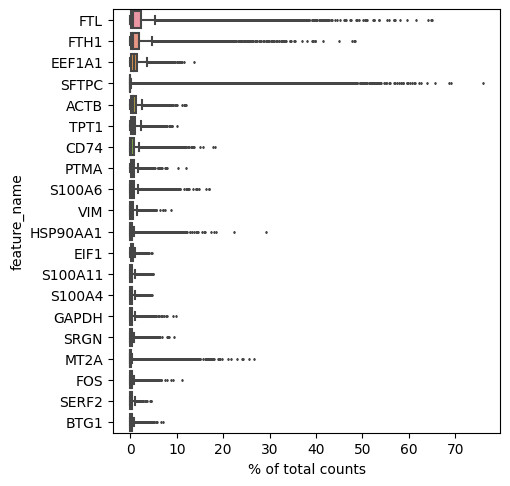

In [22]:
sc.pl.highest_expr_genes(lung_adata, n_top=20)

**Number of sequenced genes by assay**


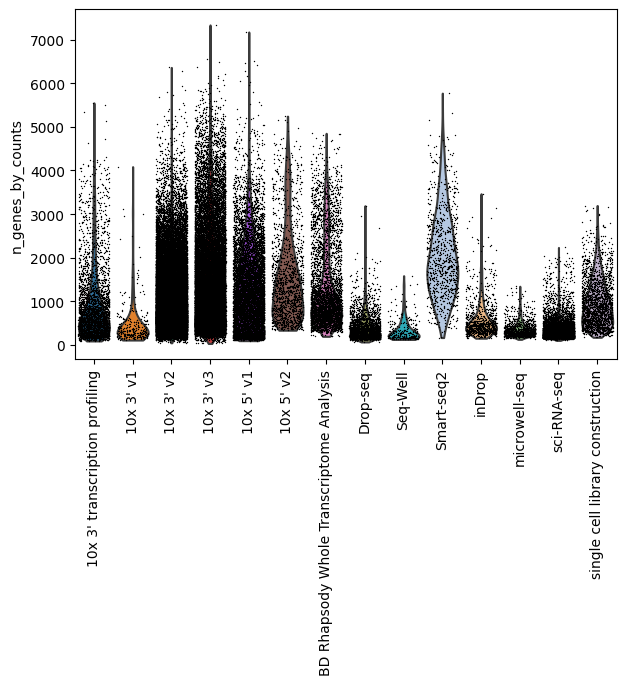

In [23]:
sc.pp.calculate_qc_metrics(lung_adata, percent_top=None, log1p=False, inplace=True)
sc.pl.violin(lung_adata, "n_genes_by_counts", groupby="assay", jitter=0.4, rotation=90)

**Total counts by assay**


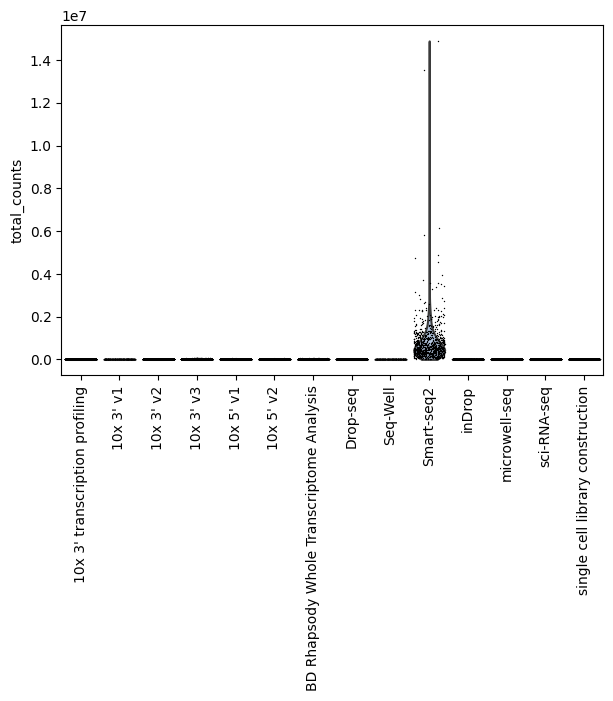

In [24]:
sc.pl.violin(lung_adata, "total_counts", groupby="assay", jitter=0.4, rotation=90)

You can see that Smart-Seq2 is an outlier for the total counts per cell, so let's exlcude it to see how the rest of the assays look like


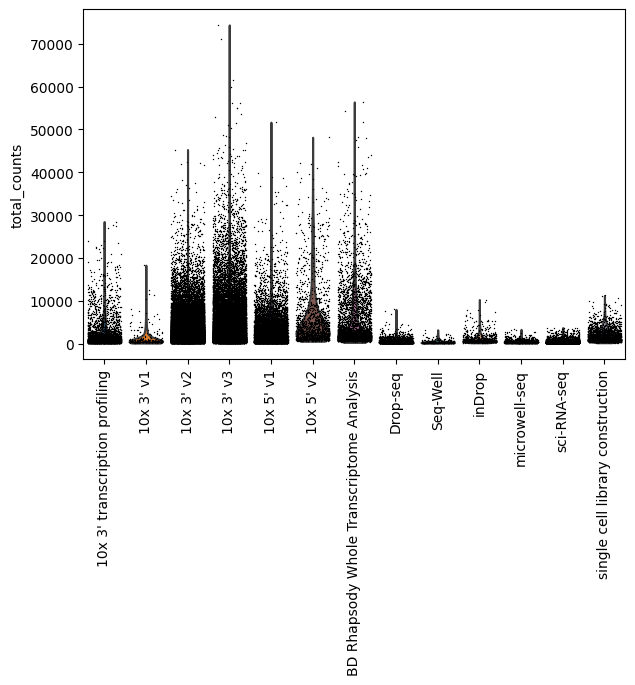

In [25]:
sc.pl.violin(
    lung_adata[lung_adata.obs["assay"] != "Smart-seq2",],
    "total_counts",
    groupby="assay",
    jitter=0.4,
    rotation=90,
)

## Creating a normalized expression layer and embeddings

Let's perform a bread and butter normalization and take a look at UMAP embeddings, but for all the data below we'll exclude Smart-seq2 as this requires an extra step to normalize based on gene lengths


In [26]:
lung_adata = lung_adata[lung_adata.obs["assay"] != "Smart-seq2",].copy()
lung_adata.layers["counts"] = lung_adata.X

Now let's do some basic normalization:

- Normalize by sequencing depth
- Transform to log-scale
- Select 500 highly variable genes
- Scale values across the gene axis


In [27]:
sc.pp.normalize_total(lung_adata, target_sum=1e4)
sc.pp.log1p(lung_adata)
sc.pp.highly_variable_genes(lung_adata, n_top_genes=500, flavor="seurat_v3", layer="counts")
lung_adata = lung_adata[:, lung_adata.var.highly_variable]
sc.pp.scale(lung_adata, max_value=10)

/home/ssm-user/cellxgene-census/venv/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/home/ssm-user/cellxgene-census/venv/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


And reduce dimensionality by obtaining UMAP embeddings.


In [28]:
sc.tl.pca(lung_adata)
sc.pp.neighbors(lung_adata)
sc.tl.umap(lung_adata)

/home/ssm-user/cellxgene-census/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


And plot these embeddings.


In [29]:
n_cell_types = len(lung_adata.obs["cell_type"].drop_duplicates())

from random import randint

colors = []

for i in range(len(lung_adata.obs["cell_type"].drop_duplicates())):
    colors.append("#%06X" % randint(0, 0xFFFFFF))

/home/ssm-user/cellxgene-census/venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


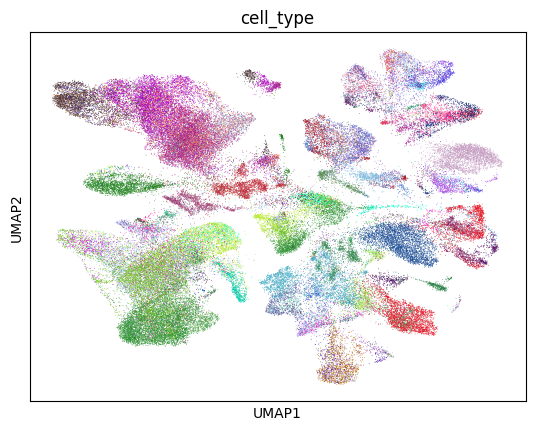

In [30]:
sc.pl.umap(lung_adata, color="cell_type", palette=colors, legend_loc=None)

Let's color by assay.


/home/ssm-user/cellxgene-census/venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


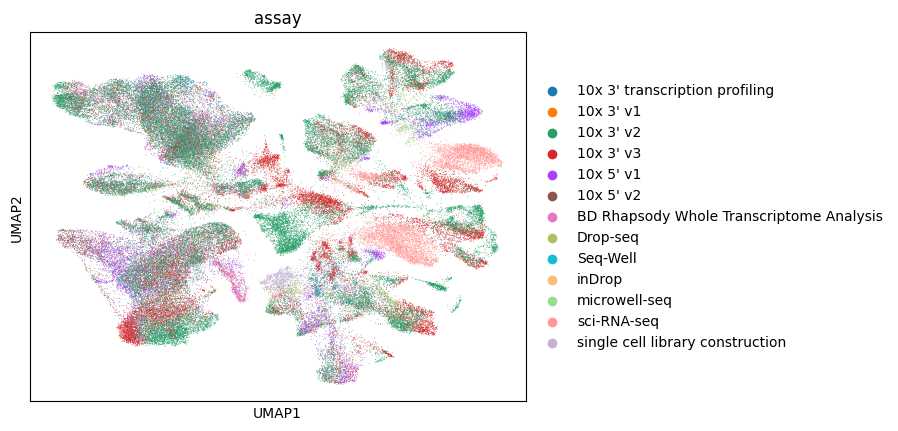

In [31]:
sc.pl.umap(lung_adata, color="assay")

Given the high number of cell types it makes it hard to visualize, so let's look at the top 20 most abundant cell types.


In [32]:
top_cell_types = lung_adata.obs["cell_type"].value_counts()
top_cell_types = list(top_cell_types.reset_index().head(20)["cell_type"])

/home/ssm-user/cellxgene-census/venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


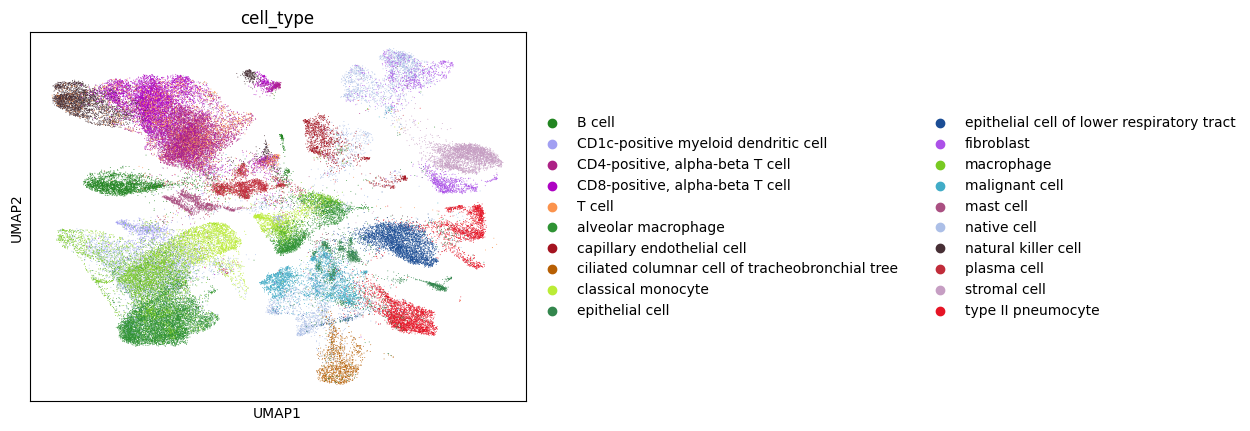

In [33]:
lung_adata_top_cell_types = lung_adata[[i in top_cell_types for i in lung_adata.obs["cell_type"]], :]
sc.pl.umap(lung_adata_top_cell_types, color="cell_type")

Let's color by assay of this subset of the data.


/home/ssm-user/cellxgene-census/venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


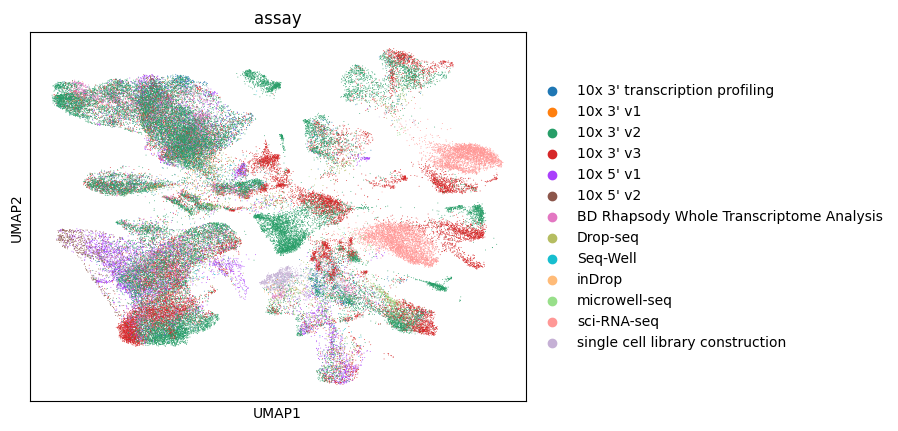

In [34]:
sc.pl.umap(lung_adata_top_cell_types, color="assay")